In [1]:
import sys
import torch
import numpy as np
import pickle as pkl
import os

sys.path.append('../../../')


from experiments.supervised.product_manifold.script import product_manifold, plot_networks
from riemannian_geometry.computations.pullback_metric import pullback_all_metrics
from models.supervised.mlp.model import MLP

models_path = "../../../models/supervised/mlp/saved_models"


In [2]:
np.random.seed(2)
torch.manual_seed(2)

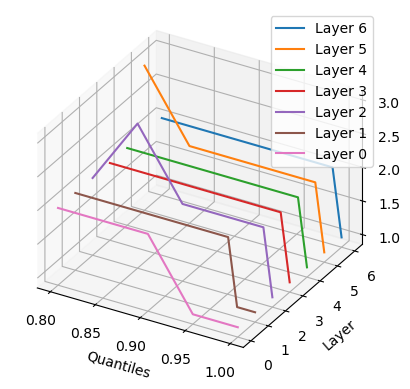

In [53]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d', proj_type='ortho')
ax.set_xlabel('Quantiles')
ax.set_ylabel('Layer')
ax.set_zlabel('Number of components')

for layer in reversed(range(0, len(model.layers))):
	indices = np.arange(len(activations_np[layer]))
	surface_ = surface[layer][indices].copy()
	activations_np_ = activations_np[layer][indices].copy()
	g_ = g[layer][indices].copy()

	V = np.linalg.norm(g_, axis=(1,2), ord="fro")

	components_pin, graphs_pin, removed_nodes, quantiles = product_manifold(surface_, V, plot=False, size=size, mode=mode, use_pin=False)

	ax.plot(quantiles, layer*np.ones_like(quantiles), zs=[len(c) for c in components_pin[1:]], label=f"Layer {layer}")
plt.legend()
ax.legend(loc='upper right')
if not os.path.exists(f"figures/{mode}/{size}"):
	os.makedirs(f"figures/{mode}/{size}")
plt.savefig(f"figures/{mode}/{size}/components_3d.png")

In [134]:

"""
Code for the Modified Geometric Manifold Component Estimator (GEOMANCER). 
Largerly based off the DeepMind paper ``Disentangling by Subspace Diffusion``
"""

import itertools

from absl import logging

import numpy as np
import scipy
import scipy.sparse
import scipy.sparse.linalg
from sklearn.neighbors import NearestNeighbors
from tqdm import tqdm

def sym_op(x, zero_trace=False):
	"""Given X, makes L(A) = X @ A @ X' for symmetric matrices A.

	If A is not symmetric, L(A) will return X @ (A_L + A_L') @ X' where A_L is
	the lower triangular of A (with the diagonal divided by 2).

	Args:
		x: The matrix from which to construct the operator
		zero_trace (optional): If true, restrict the operator to only act on
			matrices with zero trace, effectively reducing the dimensionality by one.
	Returns:
		A matrix Y such that vec(L(A)) = Y @ vec(A).
	"""
	n = x.shape[0]
	# Remember to subtract off the diagonal once
	xx = (np.einsum('ik,jl->ijkl', x, x) +
				np.einsum('il,jk->ijkl', x, x) -
				np.einsum('ik,jl,kl->ijkl', x, x, np.eye(n)))
	xx = xx[np.tril_indices(n)]
	xx = xx.transpose(1, 2, 0)
	xx = xx[np.tril_indices(n)]
	xx = xx.T
	if zero_trace:
		diag_idx = np.cumsum([0]+list(range(2, n)))
		proj_op = np.eye(n*(n+1)//2)[:, :-1]
		proj_op[-1, diag_idx] = -1
		# multiply by operator that completes last element of diagonal
		# for a zero-trace matrix
		xx = xx @  proj_op
		xx = xx[:-1]
	return xx


def vec_to_sym(x, n, zero_trace=False):
	y = np.zeros((n, n))
	if zero_trace:
		x = np.append(x, 0.0)
	y[np.tril_indices(n)] = x
	y += y.T
	y[np.diag_indices(n)] /= 2.0
	if zero_trace:
		y[-1, -1] = -np.trace(y)
	return y


def ffdiag(data, lr=1.0, tol=1e-10, verbose=False, eig_init=False):
	"""Orthogonal FFDiag algorithm of Ziehe et al 2004."""
	n = data.shape[1]
	k = data.shape[0]
	c = data.copy()
	if eig_init:
		_, v = np.linalg.eig(data[0])
		v = v.T
		for i in range(k):
			c[i] = v @ c[i] @ v.T
	else:
		v = np.eye(n)

	err_ = np.inf
	for t in range(10000):
		w = np.zeros((n, n))
		for i in range(n):
			for j in range(i+1, n):
				diag = c[:, i, i] - c[:, j, j]
				w[i, j] = np.sum(c[:, i, j] * diag) / np.sum(diag ** 2)
		w -= w.T
		norm = np.linalg.svd(w, compute_uv=False).max()
		if norm > lr:
			w *= lr / norm
		ew = scipy.linalg.expm(w)
		v = ew @ v
		for i in range(k):
			c[i] = ew @ c[i] @ ew.T
		cdiag = c.copy()
		for i in range(n):
			for j in range(k):
				cdiag[j, i, i] = 0
		err = np.linalg.norm(cdiag)
		if verbose:
			logging.info('Iter %d: %f', t, err)
		if err_ - err < tol and err_ - err >= 0:
			return v
		err_ = err
	return v


def avg_angle_between_subspaces(xs, ys):
	"""Compute the error between two sets of subspaces."""
	if len(xs) != len(ys):
		return np.pi / 2  # largest possible angle
	angles = []
	for ys_perm in itertools.permutations(ys):
		angles.append([])
		for i in range(len(xs)):
			if xs[i].shape[1] == ys_perm[i].shape[1]:
				sigma = np.linalg.svd(xs[i].T @ ys_perm[i], compute_uv=False)
				angles[-1].append(np.arccos(np.min(sigma)))
			else:
				angles[-1].append(np.pi / 2)
	angles = np.array(angles)
	return np.min(np.mean(angles, axis=1))


def make_nearest_neighbors_graph(data, k):
	n = data.shape[0]
	nbrs = NearestNeighbors(n_neighbors=k+1, algorithm='auto').fit(data)
	distances, indices = nbrs.kneighbors(data)

	row_indices = np.repeat(indices[:, 0], k)
	col_indices = indices[:, 1:].reshape(-1)
	data = np.ones(row_indices.shape[0])

	# Create a sparse matrix in COO format
	nbr_graph = scipy.sparse.coo_matrix((data, (row_indices, col_indices)), shape=(n, n))

	# Make the graph symmetric by adding its transpose
	nbr_graph = nbr_graph + nbr_graph.T
	nbr_graph.data = np.where(nbr_graph.data >= 1, 1, 0)

	# Convert to CSR format for efficient arithmetic and storage
	nbr_graph = nbr_graph.tocsr()

	return nbr_graph

def make_tangents_from_metric_eigenvectors(metric_g):
	eigenvalues, tangents = np.linalg.eig(metric_g)
	tangents = tangents / eigenvalues[:, :, np.newaxis]
	return tangents


def make_tangents(data, neighbor_graph, k, remaining_nodes):
	"""Construct all tangent vectors for the dataset."""
	tangents = np.zeros((data.shape[0], k, data.shape[1]), dtype=np.float32)
	for i in tqdm(remaining_nodes):
		# Adapted for CSR format
		diff = data[neighbor_graph.rows[i]] - data[i]
		_, _, u = np.linalg.svd(diff, full_matrices=False)
		tangents[i] = u[:k]
	logging.info('Computed all tangents')
	return tangents

def make_connection(tangents, neighbor_graph):
	"""Make connection matrices for all edges of the neighbor graph."""
	connection = {}
	for i in tqdm(range(tangents.shape[0])):
		for j in neighbor_graph.rows[i]:
			if j > i:
				uy, _, ux = np.linalg.svd(tangents[j] @ tangents[i].T,
										  full_matrices=False)
				conn = uy @ ux
				connection[(i, j)] = conn
				connection[(j, i)] = conn.T
	logging.info('Constructed all connection matrices')
	return connection

def make_laplacian(connection, neighbor_graph, remaining_nodes, sym=True, zero_trace=True):
	"""Make symmetric zero-trace second-order graph connection Laplacian."""
	n = len(remaining_nodes)
	k = list(connection.values())[0].shape[0]
	bsz = (k*(k+1)//2 - 1 if zero_trace else k*(k+1)//2) if sym else k**2
	data = np.zeros((neighbor_graph.nnz + n, bsz, bsz), dtype=np.float32)
	indptr = []
	indices = np.zeros(neighbor_graph.nnz + n)
	index = 0
	for i in tqdm(remaining_nodes):
		indptr.append(index)
		data[index] = len(neighbor_graph.rows[i]) * np.eye(bsz)
		indices[index] = i
		index += 1
		for j in neighbor_graph.rows[i]:
			if sym:
				kron = sym_op(connection[(j, i)], zero_trace=zero_trace)
			else:
				kron = np.kron(connection[(j, i)], connection[(j, i)])
			data[index] = -kron
			indices[index] = j
			index += 1
	indptr.append(index)
	indptr = np.array(indptr)

	laplacian = scipy.sparse.bsr_matrix((data, indices, indptr),
																			shape=(n*bsz, n*bsz))
	logging.info('Built 2nd-order graph connection Laplacian.')
	return laplacian


def cluster_subspaces(omega):
	"""Cluster different dimensions from the eigenvectors of the Laplacian."""
	w = ffdiag(omega)  # simultaneous diagonalization
	psi = np.zeros(omega.shape[:2])
	for i in range(omega.shape[0]):
		psi[i] = np.diag(w @ omega[i] @ w.T)  # compute diagonals
	# Compute cosine similarity of diagonal vectors
	psi_outer = psi.T @ psi
	psi_diag = np.diag(psi_outer)
	cos_similarity = psi_outer / np.sqrt(np.outer(psi_diag, psi_diag))
	adj = cos_similarity > 0.5  # adjacency matrix for graph of clusters
	# Use graph Laplacian to find cliques
	# (though a greedy algorithm could work too)
	lapl = np.diag(np.sum(adj, axis=0)) - adj  # graph Laplacian
	d, v = np.linalg.eig(lapl)
	# connected components of graph
	cliques = np.abs(v[:, np.abs(d) < 1e-6]) > 1e-6
	tangents = [w[cliques[:, i]] for i in range(sum(np.abs(d) < 1e-6))]
	
	manifold_membership = {}
	for i in range(len(tangents)):
		manifold_membership[i] = []
		for j in range(len(tangents[i])):
			manifold_membership[i].append(np.where(cliques[:, i])[0][j])
	return tangents

def fit(data, k, metric_g, neighbor_graph, remaining_nodes, gamma=None, neig=10):
	"""The Geometric Manifold Component Estimator.

	Args:
		data: the dataset, a set of points sample from a product manifold.
		k: the dimensionality of the manifold.
		metric_g: the metric tensor at each point of the dataset.
		neighbor_graph: a sparse matrix representing the nearest neighbor graph
		gamma (optional): the threshold in the spectrum at which to cut off the
			number of submanifolds.

	Returns:
		A list of lists of subspace bases, one list for each element of the dataset,
		and the spectrum of the 2nd-order graph Laplacian.
	"""
	tangents = make_tangents_from_metric_eigenvectors(metric_g)
	#tangents = make_tangents(data, neighbor_graph, k, remaining_nodes)
	connection = make_connection(tangents, neighbor_graph)
	laplacian = make_laplacian(connection, neighbor_graph, remaining_nodes)
	eigvals, eigvecs = scipy.sparse.linalg.eigsh(laplacian, k=neig, which='SM')
	logging.info('Computed bottom eigenvectors of 2nd-order Laplacian')
	bsz = k*(k+1)//2 - 1  # Block size for the projected 2nd-order Laplacian
	if gamma:
		nm = np.argwhere(eigvals < gamma)[-1, 0] + 1
	else:  # If no threshold is provided, just use the largest gap in the spectrum
		nm = np.argmax(eigvals[1:] - eigvals[:-1]) + 1
	eigvecs = eigvecs.reshape(len(remaining_nodes), bsz, neig)
	omega = np.zeros((nm, k, k), dtype=np.float32)
	components = []
	for i in tqdm(range(len(remaining_nodes))):
		for j in range(nm):
			omega[j] = vec_to_sym(eigvecs[i, :, j], k, zero_trace=True)
		components.append([tangents[i].T @ x.T for x in cluster_subspaces(omega)])
	logging.info('GEOMANCER completed')
	return components, eigvals, eigvecs


def eval_aligned(tangents, true_tangents):
	"""Evaluation for aligned data."""
	errors = np.zeros(len(tangents))
	for i in tqdm(range(len(tangents))):
		errors[i] = avg_angle_between_subspaces([gt[i] for gt in true_tangents],
																						tangents[i])
	logging.info('Computed angles between ground truth and GEOMANCER results')
	return errors


def eval_unaligned(data, tangents, true_data, true_tangents, k=10):
	"""Evaluation for unaligned data."""
	logging.info('Evaluating unaligned data')
	errors = np.zeros(data.shape[0])
	nbrs = make_nearest_neighbors_graph(true_data, k=k)

	for i in tqdm(range(data.shape[0])):
		tangent = np.concatenate(tangents[i], axis=1)
		true_tangent = np.concatenate([t[i] for t in true_tangents], axis=1)
		dx_true = (true_data[nbrs.rows[i]] - true_data[i]) @ true_tangent
		dx_result = (data[nbrs.rows[i]] - data[i]) @ tangent

		# compute canonical correlations between the two dxs
		xx = dx_true.T @ dx_true
		yy = dx_result.T @ dx_result
		xy = dx_true.T @ dx_result
		xx_ = np.linalg.inv(xx)
		yy_ = np.linalg.inv(yy)
		foo = scipy.linalg.sqrtm(xx_) @ xy @ scipy.linalg.sqrtm(yy_)
		u, _, v = np.linalg.svd(foo)

		# project subspaces for results and ground truth into aligned space
		proj = [v @ tangent.T @ s for s in tangents[i]]
		true_proj = [u.T @ true_tangent.T @ s[i] for s in true_tangents]
		errors[i] = avg_angle_between_subspaces(proj, true_proj)
	return errors



In [147]:
size = "vanilla"
mode = "blobs"
epoch = 199
model = MLP(2,7,4,4)
with open(f'{models_path}/{size}/mlp_{mode}/dataset.pkl', 'rb') as f:
	dataset = pkl.load(f)

full_path = f'{models_path}/{size}/mlp_{mode}/model_{epoch}.pth'
model.load_state_dict(torch.load(full_path))
if size == "overfit":
	model.num_layers -= 1
	model.layers = model.layers[:-1]
model.eval()


MLP(
  (layers): ModuleList(
    (0): Layer(
      (act_func): Tanh()
      (linear_map): Linear(in_features=2, out_features=4, bias=True)
    )
    (1-5): 5 x Layer(
      (act_func): Tanh()
      (linear_map): Linear(in_features=4, out_features=4, bias=True)
    )
    (6): Layer(
      (act_func): Sigmoid()
      (linear_map): Linear(in_features=4, out_features=4, bias=True)
    )
  )
)

In [148]:
N=50
wrt = "output_wise"
sigma = 0.05

X = torch.from_numpy(dataset.X).float()
labels = dataset.y


model.forward(X, save_activations=True)

activations = model.get_activations()
activations_np = [a.detach().numpy() for a in activations]
g, dg, ddg, surface = pullback_all_metrics(model, activations, N, wrt=wrt, method="manifold", sigma=sigma, normalised=False)

layer = 0
indices = np.arange(len(activations_np[layer]))
surface_ = surface[layer][indices].copy()
activations_np_ = activations_np[layer][indices].copy()
g_ = g[layer][indices].copy()

V = np.linalg.det(g_)

components_pin, graphs_pin, removed_nodes, quantiles = product_manifold(surface_, V, plot=False, size=size, mode=mode, use_pin=False)

In [154]:
quantiles = np.array(quantiles)
chosen_quartile = np.argwhere(quantiles == 0.95)[0][0]+1
bool_ = np.ones(len(surface_), dtype=bool)
bool_[removed_nodes[chosen_quartile]] = False
remaining_nodes = np.argwhere(bool_).flatten()

In [149]:
fig, ax = plt.subplots(2,2, figsize=(10,10))


ax[0][0].scatter(surface_[remaining_nodes, 0], surface_[remaining_nodes, 1])

In [150]:
c = sorted(components_pin[chosen_quartile], key=len, reverse=True)

100%|██████████| 950/950 [00:03<00:00, 258.63it/s]


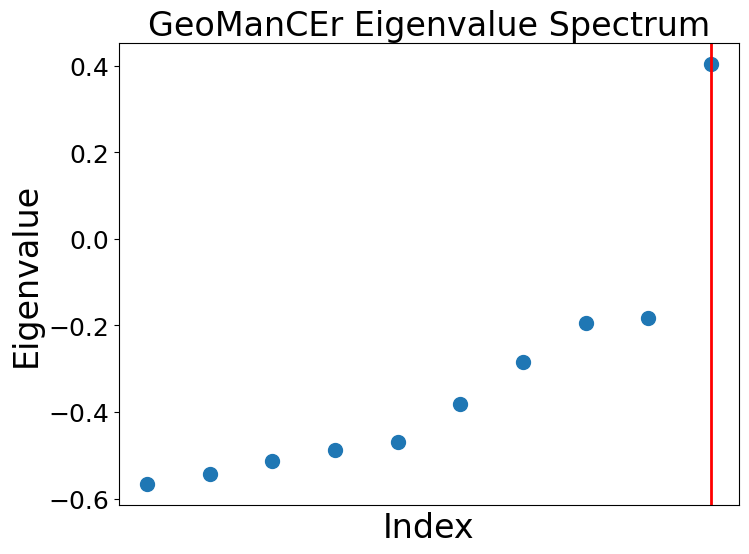

/var/folders/b_/x8lg97sd7512c9qf07myy77m0000gn/T/ipykernel_9271/4271077544.py:30: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(surface_[cc][:,0], surface_[cc][:,1], cmap="RdBu_r", alpha=0.4, s=10)


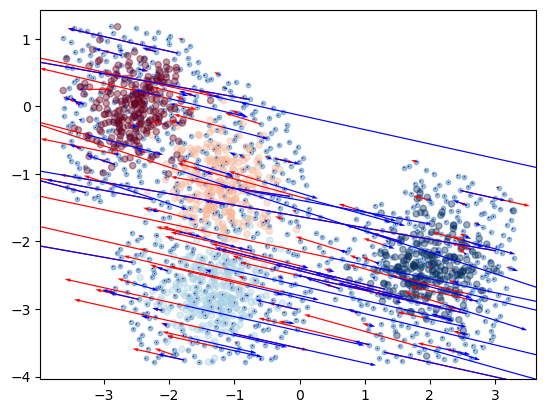

In [151]:
import networkx as nx
import scipy
import matplotlib.pyplot as plt

for cc in c:
    Graph = graphs_pin[chosen_quartile]
    full_nodes = max(Graph.keys())
    nnbr_graph = scipy.sparse.lil_matrix((full_nodes+1, full_nodes+1))
    for i in cc:
        for j in Graph[i]:
            nnbr_graph[i,j] = 1
            nnbr_graph[j,i] = 1
    
    components_geo, eigenvals_geo, eigenvectors_geo = fit(surface_, 2, g_, nnbr_graph, gamma=None, neig=10, remaining_nodes=cc)
    components_np = np.array(components_geo).squeeze()
    cc = list(cc)

    plt.figure(figsize=(8, 6))
    plt.scatter(np.arange(len(eigenvals_geo)), eigenvals_geo, s=100)
    largest_gap = np.argmax(eigenvals_geo[1:]-eigenvals_geo[:-1]) + 1
    plt.axvline(largest_gap, linewidth=2, c='r')
    plt.xticks([])
    plt.yticks(fontsize=18)
    plt.xlabel('Index', fontsize=24)
    plt.ylabel('Eigenvalue', fontsize=24)
    plt.title('GeoManCEr Eigenvalue Spectrum', fontsize=24)
    plt.show()


    plt.scatter(surface_[cc][:,0], surface_[cc][:,1], cmap="RdBu_r", alpha=0.4, s=10)
    plt.scatter(activations_np[layer][:,0], activations_np[layer][:,1], c=dataset.y, cmap="RdBu_r", alpha=0.4, s=20)
    plt.quiver(surface_[cc][:,0], surface_[cc][:,1], components_np[:,0,0], components_np[:,0,1], color="red")
    plt.quiver(surface_[cc][:,0], surface_[cc][:,1], components_np[:,1,0], components_np[:,1,1], color="blue")
    plt.show()



100%|██████████| 900/900 [00:02<00:00, 435.19it/s]


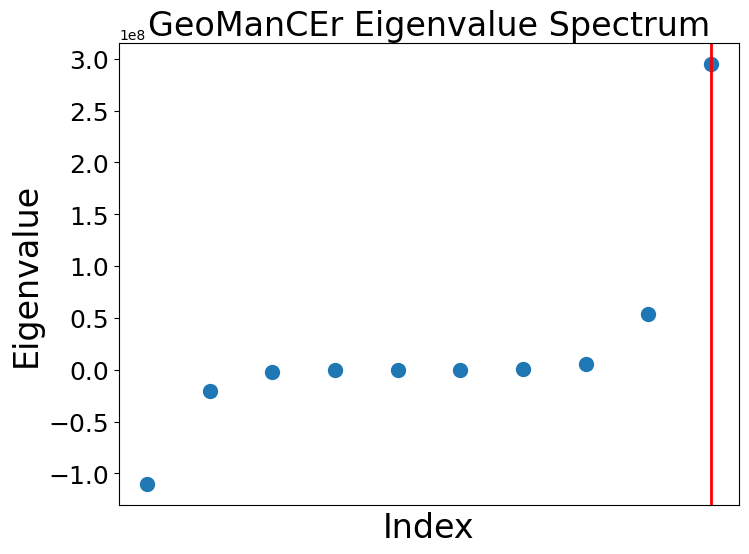

/var/folders/b_/x8lg97sd7512c9qf07myy77m0000gn/T/ipykernel_9271/1387607881.py:25: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(surface_[remaining_nodes][:,0], surface_[remaining_nodes][:,1], cmap="RdBu_r", alpha=0.4, s=10)


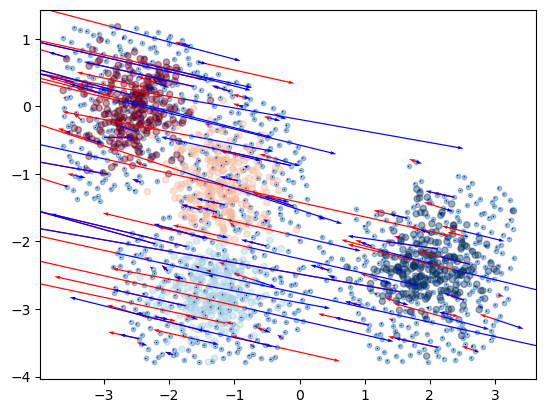

In [152]:
Graph = graphs_pin[chosen_quartile]
full_nodes = max(Graph.keys())
nnbr_graph = scipy.sparse.lil_matrix((full_nodes+1, full_nodes+1))
for i in remaining_nodes:
    for j in Graph[i]:
        nnbr_graph[i,j] = 1
        nnbr_graph[j,i] = 1
    
components_geo, eigenvals_geo, eigenvectors_geo = fit(surface_, 2, g_, nnbr_graph, gamma=None, neig=10, remaining_nodes=remaining_nodes)
components_np = np.array(components_geo).squeeze()
remaining_nodes = list(remaining_nodes)

plt.figure(figsize=(8, 6))
plt.scatter(np.arange(len(eigenvals_geo)), eigenvals_geo, s=100)
largest_gap = np.argmax(eigenvals_geo[1:]-eigenvals_geo[:-1]) + 1
plt.axvline(largest_gap, linewidth=2, c='r')
plt.xticks([])
plt.yticks(fontsize=18)
plt.xlabel('Index', fontsize=24)
plt.ylabel('Eigenvalue', fontsize=24)
plt.title('GeoManCEr Eigenvalue Spectrum', fontsize=24)
plt.show()


plt.scatter(surface_[remaining_nodes][:,0], surface_[remaining_nodes][:,1], cmap="RdBu_r", alpha=0.4, s=10)
plt.scatter(activations_np[layer][:,0], activations_np[layer][:,1], c=dataset.y, cmap="RdBu_r", alpha=0.4, s=20)
plt.quiver(surface_[remaining_nodes][:,0], surface_[remaining_nodes][:,1], components_np[:,0,0], components_np[:,0,1], color="red")
plt.quiver(surface_[remaining_nodes][:,0], surface_[remaining_nodes][:,1], components_np[:,1,0], components_np[:,1,1], color="blue")
plt.show()

In [106]:

components_geo, eigenvectors_geo, eigenvalues_geo = fit(surface_, 2, g_, nnbr_graph, gamma=None, neig=10, remaining_nodes=remaining_nodes)


100%|██████████| 900/900 [00:02<00:00, 342.87it/s]


/var/folders/b_/x8lg97sd7512c9qf07myy77m0000gn/T/ipykernel_9271/3698328898.py:4: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(surface_[cc][:,0], surface_[cc][:,1], cmap="RdBu_r", alpha=0.4, s=10)


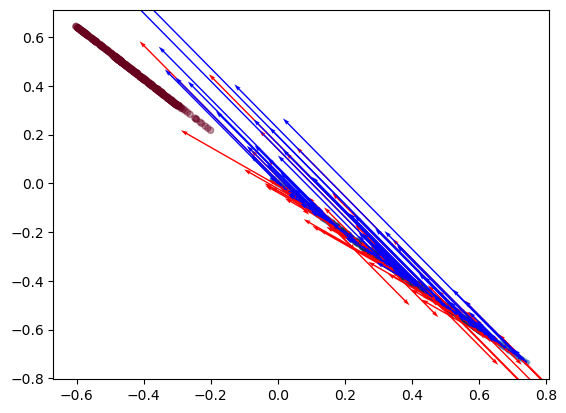

In [130]:
components_np = np.array(components_geo).squeeze()
import matplotlib.pyplot as plt
plt.scatter(surface_[cc][:,0], surface_[cc][:,1], cmap="RdBu_r", alpha=0.4, s=10)
plt.scatter(activations_np[layer][:,0], activations_np[layer][:,1], c=dataset.y, cmap="RdBu_r", alpha=0.4, s=20)
plt.quiver(surface_[cc][:,0], surface_[cc][:,1], components_np[:,0,0], components_np[:,0,1], color="red")
plt.quiver(surface_[cc][:,0], surface_[cc][:,1], components_np[:,1,0], components_np[:,1,1], color="blue")
